In [1]:
#| default_exp poisson

from nbdev.showdoc import *
from utilities.ipynb_docgen import *
import matplotlib.pyplot as plt

Author(s): Eric Wallace, Matthew Kerr, Toby Burnett

In [2]:
#| export
import sys, warnings
import numpy as np
from numpy import polyfit
from scipy import optimize, special, stats

class Poisson(object):
    r"""This is a functor class which returns the log of a three-parameter Poisson-like function used to represent
    the flux likelihood. The parameters are, in order:

    $s_p$ : flux at peak, the maximum likelihood, if positive; if negative, there is a limit

    $e$ : normalization factor to convert flux to equivalent counts. must be >0

    $b$  : background flux: must be >=0

    This parameterization is equivalent to that described in William Tompkins' thesis
    (arxiv: astro-ph/0202141) and Nolan, et al., 2003,  ApJ 597:615:627.
    The functional form is that of a Poisson distribution.

    The log likelihood expression is for flux $s>=0$
       $$w(s | s_p,e,b) = e\ \big[\  (s_p+b) \ \log( s+b ) - s\ \big] + \mathrm{const}$$
    the const is conventionally defined such that $w=0$ at the peak.

    for s_p >> b, the solution can be expressed as

    $$ s = s_p \pm \sqrt{(s_p+b)/e}$$

    A slightly more elegant expression, used in the cdf function, is to define
       $\beta = e b$,  $\mu = e s_p + \beta$, and  $x = e s$.

    Then the log likelihood is

       $$ f(x | \beta) =  \mu \ \log( x + \beta) - x + \mathrm{const}$$

    where the peak is at $x=x_p=\max(0, \mu-\beta)$, and the constant is defined so that $f(x_p)=0$.

    """

    def __init__(self, p:[]):
        """p : array of parameters
        """
        self.p = p

    def __call__(self, dom):
        """Return the value(s) of the fit function for the given domain."""
        sp,e,b = self.p
        b = abs(b) # this is a bit of a kluge to keep log argument positive
        if b==0: b = 1e-20 #another kludge
        e = abs(e) #and another
        r = e*(dom+b)
        r_peak = e*(sp+b)
        if sp > 0:
            const = r_peak*np.log(r_peak) - r_peak
        else:
            #sp=0
            #const = r_peak*np.log(r_peak) - r_peak
            t = e*b
            const = r_peak*np.log(t) - t
        f = r_peak*np.log(r) - r
        return f - const

    def __str__(self):
        return self.__repr__()
        # e, beta, mu = self.altpars()
        # return f'Poisson: mu,beta= {mu:.1f}, {beta:.1f}'

    def __repr__(self):
        if self.flux==0:
            return '0'
        t = np.array(self.errors)/self.flux-1
        relerr = np.abs(np.array(self.errors)/self.flux-1)
        # return f'{self.__module__}.{self.__class__.__name__}: {self.flux:.3f}[1+{relerr[0]:.3f}-{relerr[1]:.3f}]'
        return f'{self.flux:.3f}[1+{relerr[0]:.3f}-{relerr[1]:.3f}]'

    @property
    def flux(self):
        if np.isnan(self.p[1]): return 0
        return max(self.p[0], 0)

    @property
    def errors(self):
        return self.find_delta()

    @property
    def limit(self):
        """ 95% confidence interval"""
        return self.cdfcinv(0.05)

    @property
    def ts(self):
        if np.isnan(self.p[1]): return np.nan
        return 0 if self.flux<=0 else (self(self.flux)-self(0))*2.0


    def altpars(self):
        """ return alternate parameters: e, beta, mu """
        e = abs(self.p[1])
        beta = e * abs(self.p[2])
        mu =   e * self.p[0] + beta
        return e,beta,mu

    def find_delta(self,delta_logl=.5):
        """Find points where the function decreases by delta from the max"""
        smax = max(0,self.p[0])
        ll_max = self(smax)
        ll_zero = self(0)
        func = lambda s: ll_max-self(s)-delta_logl
        if ll_max-ll_zero<delta_logl:
            s_low = 0
        else:
            #s_low = optimize.bisect(func,0,smax,xtol=.01*smax)
            s_low = optimize.brentq(func,0,smax,xtol=1e-17)
        if smax>0:
            s_high = smax*10
        else:
            s_high = 1e-15
        while func(s_high)<0: s_high*=2
        #s_high = optimize.bisect(func,smax,s_high,xtol=.01*smax)
        s_high = optimize.brentq(func,smax,s_high,xtol=1e-17)
        if not np.all(np.isreal([s_low,s_high])):
            print('Could not find two roots!')
            return None
        return (s_low,s_high)

    def cdf(self, flux ):
        """ cumulative pdf, from flux=0, according to Bayes
        uses incomplete gamma function for integrals. (Note that the scipy function
        is a regularized incomplete gamma function)
        """
        e, beta, mu = self.altpars()
        offset = special.gammainc(mu+1, beta) # Bayes offset if beta>0
        return (special.gammainc(mu+1, beta+flux*e)-offset)/(1-offset)

    def cdfc(self,flux):
        """ complementary cumulative cdf: 1-cdf(flux)"""
        e, beta, mu = self.altpars()
        return special.gammaincc(mu+1, beta+flux*e)/special.gammaincc(mu+1, beta)

    def cdfinv(self, pval):
        """ return the inverse of the cdf
         pval : float
        """
        e,beta,mu = self.altpars()
        gbar = lambda x : special.gammainc(mu+1, beta+x)
        chatinv = lambda pv : special.gammaincinv(mu+1, pv+gbar(0)*(1-pv))-beta
        return  chatinv(pval)/e

    def cdfcinv(self, pvalc):
        """ return the inverse of cdfc = 1-cdf
        useful for limits with very low probablity
        pvalc : float
            1-pval: zero corresponds to infinite flux
        """
        e,beta,mu = self.altpars()
        if e==0: return np.nan
        gcbar = lambda x : special.gammaincc(mu+1, beta+x)
        #cchat = lambda x : gcbar(x)/gcbar(0)
        cchatinv = lambda pv : special.gammainccinv( mu+1, pv*gcbar(0) )-beta
        return cchatinv(pvalc)/e

    def percentile(self, limit=0.95):
        """Left for compatibility: use cdfinv or cdfcinv
        """
        if limit>=0.95: return self.cdfcinv(1-limit)
        return self.cdfinv(limit)

    def pts(self):
        return 0 if self.flux<=0 else (self(self.flux)-self(0))*2.0

    def zero_fraction(self):
        """ Return an estimate of the fraction of the probability that corresponds
        to negative flux. Assume only have to calculate if TS>0 or TS<16
        """
        if self.ts==0: return 1.0
        if self.ts>16: return 0.0
        #this assumes that self.cdfc(0) is 1.0, and that cdfc(-b) is the full integral
        return 1-1./self.cdfc(-self.p[2])

    def sigma_dev(self, val):
        """Express the deviation of `val` from compatibility with this PDF using a sigma measure"""
        # norm(0,1).isf is inverse survival probability for Gaussian
        return stats.norm(0,1).isf(self.cdf(val))

    @classmethod
    def from_fit(cls, counts, flux, sig_flux, tol=5):
        r"""
        Create a Poisson instance using the fit parameters from an analysis
        of a likelihood function.

        - counts -- number of weights
        - flux -- peak value, in flux units
        - sig_flux -- its standard deviation, square root of the variance

        This is relevant if the likelihood is not truncated by the Bayes requirement.

        If $s$ and $v$ are the signal rate and its variance, determined by an optimization for $n$ measurements,
        so $s$ is large compared with $\sqrt{v}$, then the poisson-like parameters can be determined as follows.

        We use the properties of the Poisson distribution
        $f(n|\ lambda) = \exp(n \log\lambda - \lambda + \mathrm{const})$,
        where the parameter $\lambda$ is equal to the expected value of number of occurrences $n$ and
        to its variance, and that the function we want is shifted by the background $b$ and scaled by a factor
        $k$ so we use $f(k(s-b)| \lambda)$. This implies that for the expected value of $s$, $\lambda = n$,
        and $ k(s-b)= k^2 v = n$.

        """
        mu = counts
        beta =  counts-np.sqrt(counts)/(sig_flux/flux)
        assert beta>=0, f'std invalid, too small for number of counts'
        k = (mu-beta) /flux
        b = beta/k
        P = cls([flux, k , b])
        # check values at 0 and the peaks
        if P(0) > -tol**2/2:
            raise Exception(f'Bayes violation: P(0)= {P(0):.2f} too large for'\
                f' {tol} sigma limit. ')

        assert np.abs(P(flux))<1e-3, f'Fail validity: peak {P(mean)}'
        return P

    @classmethod
    def from_list(cls, plist, tol=0.2):
        """ Combine a list of poisson objects, adding log likelihoods
        """
        # from wtlike.poisson import PoissonFitter
        plist = np.atleast_1d(plist)
        fn = lambda x: sum([p(x) for p in plist])
        fit = PoissonFitter(fn, tol=tol)
        return fit.poiss

    @classmethod
    def from_function(cls, fn, tol=0.2):
        """Create by fitting a function
        """
        return PoissonFitter(fn, tol=tol).poiss

In [3]:
show_doc(Poisson)
show_doc(Poisson.from_fit)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/poisson.py#L191){target="_blank" style="float:right; font-size:smaller"}

### Poisson.from_fit

>      Poisson.from_fit (counts, flux, sig_flux, tol=5)

Create a Poisson instance using the fit parameters from an analysis
of a likelihood function.

- counts -- number of weights
- flux -- peak value, in flux units
- sig_flux -- its standard deviation, square root of the variance

This is relevant if the likelihood is not truncated by the Bayes requirement.

If $s$ and $v$ are the signal rate and its variance, determined by an optimization for $n$ measurements,
so $s$ is large compared with $\sqrt{v}$, then the poisson-like parameters can be determined as follows.

We use the properties of the Poisson distribution
$f(n|\ lambda) = \exp(n \log\lambda - \lambda + \mathrm{const})$,
where the parameter $\lambda$ is equal to the expected value of number of occurrences $n$ and
to its variance, and that the function we want is shifted by the background $b$ and scaled by a factor
$k$ so we use $f(k(s-b)| \lambda)$. This implies that for the expected value of $s$, $\lambda = n$,
and $ k(s-b)= k^2 v = n$.

In [4]:
# simple test: for 10K counts the error is 1% if no background 
t = Poisson.from_fit(10000, 2, 0.02 )
assert str(t)=='2.000[1+0.010-0.010]', f'Fail: got {str(t)}'

### Examples
Here we generate and plot several instances, all with the $e$ parameter set to one, so the flux is in counts.

The peak ($s_p$) and  background ($b$) parameters are chosen from the following list:

<div style="margin-left: 25px">[(10, 5), (10, 0), (-5, 5), (-5, 1), (0, 5)]</div>

The first two, with the peak at 10, show the effect of background. The last two show an example with a
peak less than zero, so that the Bayesian likelihood peaks at zero, and the effect of background on it.

<div style="margin-left: 10px"><figure style="margin-left: 10px" >   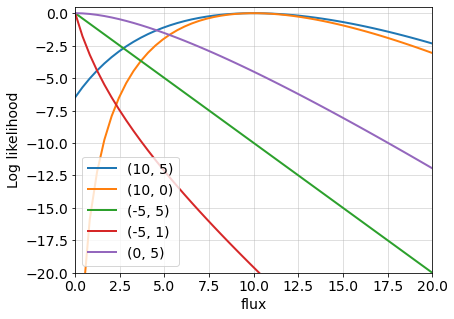 <br>  <figcaption>Poisson-like plots</figcaption></figure></div>

-----------


In [5]:
show_doc(Poisson.__call__, title_level=3 )

from utilities import nbdoc

def poisson_doc():
    """
    ### Examples
    Here we generate and plot several instances, all with the $e$ parameter set to one, so the flux is in counts.

    The peak ($s_p$) and  background ($b$) parameters are chosen from the following list:

    {pars}

    The first two, with the peak at 10, show the effect of background. The last two show an example with a
    peak less than zero, so that the Bayesian likelihood peaks at zero, and the effect of background on it.

    {fig}
    
    -----------
    """
    from wtlike.poisson import Poisson
    import matplotlib.pyplot as plt
    xlim = (0,20); ylim=(-20,0.5)

    pars = [(10,5), (10, 0), (-5, 5), (-5,1), (0,5)]

    x = np.linspace(*xlim)
    ax = plt.gca()
    fig = ax.figure
    fig.caption='Poisson-like plots'
    for p in pars:
        fun = Poisson([p[0], 1, p[1]])
        ax.plot(x, fun(x), label=str(p), lw=2) 
    ax.grid(alpha=0.5)
    ax.legend()
    ax.set(xlabel='flux', ylabel='Log likelihood', xlim=xlim, ylim=ylim);
    fig.set_facecolor('white')
    
    return locals()

nbdoc(poisson_doc)

In [6]:
#| export
class PoissonFitter(object):
    """ Helper class to fit a log likelihood function to the Poisson

    parameters
    ----------
    - func : function of one parameter
    - fmax : position of maximum value, or None
           if None, estimate using fmin
    - scale: float | None
        estimate for scale to use; if None, estimate from derivatime
    - tol : float
        absolute tolerance in probability amplitude for fit, within default domain out to delta L of 4
    - delta : float
        value to calculate numerical derivative at zero flux

    """
    # determine values of the function corresponding to delta L of 0.5, 1, 2, 4
    # depending on how peaked the function is, this will be from 5 to 8
    # The Poisson will be fit to this set of values
    dlist =  np.array([0.5, 1.0, 2.0, 4.0])

    def __init__(self, func, fmax=None, scale=None,  tol=0.20, delta=1e-4, dd=-0.1, test_mode=False):
        """
        parameters
        ----------
        func : function of one parameter
        fmax : position of maximum value, or None
               if None, estimate using fmin
        scale: float | None
            estimate for scale to use; if None, estimate from derivatime
        tol : float
            absolute tolerance in probability amplitude for fit, within default domain out to delta L of 4
        delta : float
            value to calculate numerical derivative at zero flux
        """
        self.func = func
        #first check derivative at zero flux - delta is sensitive
        self.f0 = func(0)
        s = self.wprime = (func(delta)-self.f0)/delta
        if scale is None: scale= 5/s if s>0 else 1.0
        self.smax = fmax or self.find_max(scale) if s>=0 else 0.

        self.ts = 2.*(func(self.smax) - self.f0)

        if test_mode:
            return
        dlist = self.dlist #np.array([0.5, 1.0, 2.0, 4.0])
        if s < dd:
            # large negative derivative: this will be just an exponential
            if s < -100: s=-100. #cut off for now
            self.dom = - dlist/s
            self._poiss= Poisson([-1, -s, 1])
            self.maxdev=0
            return #no test in this case
        else:
            dom = set()
            for delta in dlist:
                a,b = self.find_delta(delta, scale, xtol=tol*1e-2)
                dom.add(a); dom.add(b)
            self.dom = np.array(sorted(list(dom)))
            self.fit()
        self.maxdev=self.check(tol)[0]

    def __repr__(self):
        return '%s.%s : wprime=%.3e maxdev=%.2f, %s' % (self.__module__,self.__class__.__name__,
            self.wprime, self.maxdev,  str(self._poiss))

    @property
    def poiss(self):
        return self._poiss

    def __call__(self, x):
        if hasattr(x, '__iter__'):
            ret =list(map(self.func, x))
            return ret[0] if len(ret)==1 else ret
        return self.func(x)

    def find_max(self, scale):
        """Return the flux value that maximizes the likelihood.
        """
        # if self.func(0) > self.func(scale/10.) and self.wprime<0:
        #     return 0
        r= optimize.fmin(lambda s: -self.func(s), scale, ftol=0.01, xtol=0.01,
                disp=False, full_output=True, retall=True)
        t = r[0][0]
        #if t==scale:
        #    raise Exception('Failure to find max value: %s' % list(r))
        return t if t>0 else 0

    def find_delta(self, delta_logl=.5, scale=1.0, xtol=1e-5):
        """Find positive points where the function decreases by delta from the max
        """
        ll_max = self(self.smax)
        ll_zero = self(0)
        func = lambda s: ll_max-self(s)-delta_logl
        if ll_max-ll_zero<delta_logl:
            s_low = 0
        else:
            s_low = optimize.brentq(func,0, self.smax, xtol=xtol)
        if self.smax>0:
            s_high = self.smax*10
        else:
            s_high = scale
        while func(s_high)<0 and s_high<1e6:
            s_high*=2
        s_high = optimize.brentq(func,self.smax,s_high, xtol=xtol)
        if not np.all(np.isreal([s_low,s_high])):
            msg = '%s.find_delta Failed to find two roots!' % self.__class__.__name__
            print(msg)
            raise Exception( msg)
        if s_high==s_low:
            msg= '%s.find_delta Failed to find high root with delta=%.1f: %s' % (self.__class__.__name__,delta_logl,s_high)
            print(msg)
            print('wprime: %.3e' % self.wprime)
            raise Exception(msg)
        return (s_low,s_high)

    def fit(self, mu=30, beta=5):
        """Do the fit, return parameters for a Poisson constructor
        mu, beta: initial parameters for the fit if the peak is positive
        """
        smax = self.smax
        if smax>0:
            # function to fit has positive peak. Fit the drived parameters mu, beta
            cod = self(self.dom)-self.func(smax)
            #print 'smax=%.2f, w(smax)=%s, w(%s)=%s' % (smax,self.func(smax), self.dom, cod)
            def fitfunc(p):
                mu,beta=p
                e=(mu-beta)/smax; b = beta/e
                self._poiss = Poisson([smax, e,b])
                r = self._poiss(self.dom)-cod
                #print'f(%.3f,%.3f): %s' % (mu,beta,r)
                return r
            mu,beta =  optimize.leastsq(fitfunc,[mu,beta], ftol=1e-6,xtol=1e-6, maxfev=10000)[0]

            e = (mu-beta)/smax; b = beta/e
            return [smax, e, b]
        else:
            # maximum is at zero, so only limit.
            x=self.dom; y=self(x)
            # exposure factor estimated from asymptotic behavior
            big= x[-1]*1e3; e = -self(big)/big;
            # preliminary fit to the quadratic coeficients and estimate parameters from the linear and 2nd order
            pf = polyfit(x,y, 2)
            b,a = pf[:2]
            beta = -e*(e+a)/(2.*b)
            mu = beta*(1+a/e)
            smax= (mu-beta)/e; b= beta/e
            # now fit the Poisson with e fixed to the asym. estimate.
            cod = self(self.dom)-self(0)
            pinit = [smax,  b]
            def fitfunc(p):
                self._poiss = Poisson([p[0], e, p[1]])
                return self._poiss(x) -cod
            t =  optimize.leastsq(fitfunc,  pinit,  xtol=1e-6,ftol=1e-6, maxfev=10000)[0]
            return self._poiss.p

    def check(self, tol=0.05):
        offset = self(self.smax)
        dom =self.dom[1:] # ignore first on
        deltas = np.array([np.exp(self.func(x)-offset)-np.exp(self._poiss(x)) for x in dom])
        t = np.abs(deltas).max()
        if t>tol:
            #print(f'PoissonFitter warning: max dev= {t:.3f} > tol= {tol}. (wprime={self.wprime:.2f})', file=sys.stderr )
            txt = f'PoissonFitter: max dev= {t:.3f} > tol= {tol}. (wprime={self.wprime:.2f}'
            #warnings.warn(txt , RuntimeWarning)
            raise Exception(txt) ########################################################
        return t, deltas

    def plot(self, ax=None, xticks=True, legend=True, **kwargs ):
        """Return a figure showing the fit"""
        import matplotlib.pyplot as plt
        xp = self.dom
        x = np.linspace(0, xp[-1]*1.05, 25)
        if ax is None:
            fig, ax = plt.subplots(figsize=(3,3))
        else: fig = ax.figure
        pfmax = self(self.smax)
        ax.plot(x, np.exp(self(x)-pfmax), '-', label='Input function')
        ax.plot(xp, np.exp(self(xp)-pfmax), 'o', color='orange', label='points used for approx.')
        ax.plot(x, np.exp(self._poiss(x)), '--', lw=2,color='orange', label='Poisson approx.')
        if legend: ax.legend(loc='upper right', prop=dict(size=8) )
        kw = dict(xlim=(0,None), ylim=(0,1.05))
        kw.update(kwargs)
        ax.set(**kw)
        if xticks:
            ax.set_xticks([0, xp[-1]])
        ax.grid(alpha=0.4)
        fig.set_facecolor('white')
        return fig

    def normalization_summary(self, nominal=None):
        """return a dict with useful stuff for normalization check
            nominal: None or float
                if specified, calculate delta_ts and pull
        """
        poiss = self.poiss
        lower, upper = poiss.errors
        maxl = poiss.flux
        err = self.maxdev
        if nominal is not None:
            mf =self(nominal)
            delta_ts = 2.*(self(maxl) - mf )
        if lower>0:
            pull = np.sign(maxl-mf) * np.sqrt(max(0, delta_ts))\
            if nominal is not None else None
            summary  = dict(
                maxl=maxl,
                lower=lower, upper=upper,
                ts=self.ts, # poiss.ts,
                err=err,
                )
        else:
            # just an upper limit
            pull = -np.sqrt(max(0, delta_ts)) if nominal is not None else None
            summary= dict(maxl=0,lower=0, upper=poiss.cdfinv(0.05), ts=0,
                 err=err,
                )
        if nominal is not None:
            summary.update(delta_ts=delta_ts, pull=pull)
        return summary

In [7]:
show_doc(PoissonFitter)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/poisson.py#L244){target="_blank" style="float:right; font-size:smaller"}

### PoissonFitter

>      PoissonFitter (func, fmax=None, scale=None, tol=0.2, delta=0.0001,
>                     dd=-0.1, test_mode=False)

Helper class to fit a log likelihood function to the Poisson

### Usage 

If `func` is a log-likelihood function, the parameterized fit object is returned by

```
fpois = PoissonFitter(func).poiss

```
Test by fitting to the same functions generated in the  `Poisson` test/demo,
the  ( $s_p$, $b$ ) pairs.

<div style="margin-left: 25px">[(10, 5), (10, 0), (-5, 5), (-5, 0.5), (0, 1), (0, 10000.0)]</div>

The output shows the maximum error and the fit parameters for each test:
<div style="margin-left: 25px;"><pre>error: 2.3e-05, fit: [10.     1.     5.001]<br>error: 5.5e-04, fit: [9.997 1.    0.   ]<br>error: 8.6e-13, fit: [-1.  1.  1.]<br>error: 4.5e-02, fit: [-1.     9.999  1.   ]<br>error: 1.5e-04, fit: [0.003 0.999 0.99 ]<br>error: 1.7e-04, fit: [1.69000e-01 8.81000e-01 8.78132e+03]<br></pre></div>

Here are plots of the probability, created with `PoissonFitter.plot`, showing the input function, 
and the points that were used for the evaluation, with the output function as a dashed line. 
<div style="margin-left: 10px"><figure style="margin-left: 10px" >   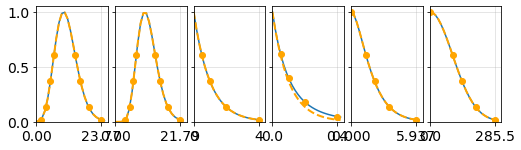 <br>  <figcaption>Fit examples.</figcaption></figure></div>


In [8]:
#| include: false
@ipynb_doc
def usage():
    """
    ### Usage 

    If `func` is a log-likelihood function, the parameterized fit object is returned by

    ```
    fpois = PoissonFitter(func).poiss

    ```
    Test by fitting to the same functions generated in the  `Poisson` test/demo,
    the  ( $s_p$, $b$ ) pairs.

    {pars}

    The output shows the maximum error and the fit parameters for each test:
    {printout}

    Here are plots of the probability, created with `PoissonFitter.plot`, showing the input function, 
    and the points that were used for the evaluation, with the output function as a dashed line. 
    {fig}

    """
    from wtlike.poisson import Poisson, PoissonFitter
    from scipy import optimize
    import matplotlib.pyplot as plt

    
    func = Poisson([10,1,5])

    pars = [(10,5), (10, 0), (-5, 5), (-5,0.5), (0, 1), (0,1e4)]

    fig, axx = plt.subplots(1,len(pars), figsize=(12,3), sharey=True)   
    plt.subplots_adjust(wspace=0.1)
    with capture_hide() as printout:
        for p,ax in zip(pars, axx.flatten() ):
            pf = PoissonFitter( Poisson([p[0], 1.0, p[-1]]) )
            print( f'error: {pf.check()[0]:.1e}, fit: {np.array(pf.poiss.p).round(3)}')
            pf.plot(ax=ax, legend=False);
    fig.caption='Fit examples.' 
    fig.width=600
    return locals()

usage()

## Tests

### Study tail when a limit

error: 4.4e-04, fit: [49.998  9.916  4.538]
50.000[1+0.045-0.046] (10, 10.0, 510.0) [50, 10, 1.0]


/tmp/ipykernel_29792/198221727.py:14: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  g,h = [derivative(p, 0.0001, 1e-4, n) for n in (1,2)]


([49.999904510304965, 10, 1.0001000868166177],
 (510.0000459712158, 10.001000868166177))

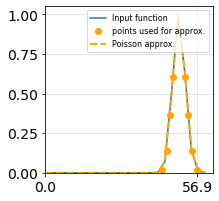

In [9]:
#| include: false
e=10
p = Poisson([5*e, e, 0.5*e])
pf = PoissonFitter(p); 
print( f'error: {pf.check()[0]:.1e}, fit: {np.array(pf.poiss.p).round(3)}')
pf.plot();

e=10
p = Poisson([5*e, e, 0.1*e])
print(p,p.altpars(), p.p)

# Derive parameters, assuming mu<0
from scipy.misc import derivative
g,h = [derivative(p, 0.0001, 1e-4, n) for n in (1,2)]

beta=-(1+g/e)/(h/e**2)
mu = beta*(1+g/e)
pars = [(mu-beta)/e, e, beta/e] 
pars, (mu,beta)

### Check high statistics, no background

In [10]:
#| include: false
for mu in np.logspace(2,6,5):
    p = Poisson([mu, 1, 0])
    print( f'Input: mu = {mu:-8.0f}', end='')
    print (f'\tFit:   {PoissonFitter(p, fmax=mu).poiss}' )

Input: mu =      100	Fit:   100.000[1+0.097-0.103]
Input: mu =     1000	Fit:   1000.000[1+0.031-0.032]
Input: mu =    10000	Fit:   10000.000[1+0.010-0.010]
Input: mu =   100000	Fit:   100000.000[1+0.003-0.003]
Input: mu =  1000000	Fit:   1000000.000[1+0.001-0.001]


In [11]:
#| include: false
import datetime
from utilities.ipynb_docgen import *
display_markdown(f'# Finish build: {str(datetime.datetime.now())[:16]}')
from nbdev import nbdev_export
nbdev_export()
!date

Obsolete: use "show"


# Finish build: 2023-06-19 11:02

Mon Jun 19 11:03:00 PDT 2023
